In [ ]:
# Функция для отрисовки grid search
!wget https://raw.githubusercontent.com/Vladimir-Dimitrov-Ngu/NLP_course/hw-2/hw_2/gridplot.py

In [ ]:
# Получаем данные
!wget https://raw.githubusercontent.com/Vladimir-Dimitrov-Ngu/NLP_course/hw-2/hw_2/data%20spam/spam_or_not_spam.csv

### Библиотеки

In [26]:
import pandas as pd
import numpy as np
import spacy
from nltk import WordPunctTokenizer
import matplotlib.pyplot as plt
import warnings

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfTransformer

from gridplot import plot_grid

warnings.filterwarnings("ignore")

RANDOM_STATE = 123
METRICS = []
MODELS = []
TUNE = []

### Первичное ознакомление

In [27]:
df = pd.read_csv("spam_or_not_spam.csv")

In [28]:
df.query("label == 0").sample(1)

,email,label
1181,in message NUMBER gNUMBERjpgfjNUMBER fsck inte...,0


In [29]:
df.query("label == 1").sample(1)

,email,label
2961,new account for zzzz URL adult club offers fre...,1


In [30]:
df["label"].value_counts()

0    2500
1     500
Name: label, dtype: int64

In [31]:
print(df.isna().sum())
df.dropna(inplace=True)

email    1
label    0
dtype: int64


In [32]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

In [33]:
df["cleaned_email"] = df["email"].apply(
    lambda x: " ".join(
        token.lemma_.lower()
        for token in nlp(x)
        if not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)

In [34]:
df[["email", "cleaned_email"]].sample(3)

,email,cleaned_email
1660,so then guido van rossum guido python org is a...,guido van rossum guido python org like basic p...
2758,dear sir madam i got this email id from your ...,dear sir madam get email d website organisatio...
2851,any way you slice it ge lifetime protector is...,way slice ge lifetime protector cut underwrite...


##### Train test split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    df["cleaned_email"], df["label"], random_state=RANDOM_STATE
)

### CountVectorizer

In [36]:
tokenizer = WordPunctTokenizer().tokenize
vectorizer = CountVectorizer(max_df=0.8, min_df=0.1, tokenizer=tokenizer)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [37]:
pd.DataFrame(
    X_train_vectorized.toarray(), columns=vectorizer.get_feature_names_out()
).head()

,add,change,click,com,come,d,date,day,don,e,...,try,use,user,ve,want,way,work,world,write,year
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,2,0,0,0,0,0,1
2,2,0,0,0,1,1,1,2,3,0,...,0,2,3,0,4,1,1,2,2,0
3,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [38]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
# Проверка на отложенной выборке
pred = model.predict(X_test_vectorized)
print(classification_report(y_test, pred, zero_division=0))
METRICS.append(f1_score(y_test, pred))
MODELS.append("Logistic")
TUNE.append(False)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       616
           1       0.92      0.72      0.81       134

    accuracy                           0.94       750
   macro avg       0.93      0.85      0.89       750
weighted avg       0.94      0.94      0.94       750


In [39]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
model.fit(X_train_vectorized, y_train)
# Проверка на отложенной выборке
pred = model.predict(X_test_vectorized)
print(classification_report(y_test, pred, zero_division=0))
METRICS.append(f1_score(y_test, pred))
MODELS.append("DecisionTree")
TUNE.append(False)

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       616
           1       0.76      0.86      0.80       134

    accuracy                           0.93       750
   macro avg       0.86      0.90      0.88       750
weighted avg       0.93      0.93      0.93       750


In [40]:
model = MultinomialNB()
model.fit(X_train_vectorized.toarray(), y_train)
# Проверка на отложенной выборке
pred = model.predict(X_test_vectorized.toarray())
print(classification_report(y_test, pred, zero_division=0))
METRICS.append(f1_score(y_test, pred))
MODELS.append("NaiveBayes")
TUNE.append(False)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       616
           1       0.91      0.80      0.85       134

    accuracy                           0.95       750
   macro avg       0.93      0.89      0.91       750
weighted avg       0.95      0.95      0.95       750


#### Подбор гиперпараметров + кросс-валидация

In [ ]:
pipe = Pipeline(
    steps=[("counter", CountVectorizer()), ("clf", LogisticRegression())]
).fit(X_train, y_train)
parameter_grid = {
    "counter__max_df": np.linspace(0.5, 0.9, 5),
    "counter__min_df": [0.01, 0.05, 0.08, 0.1],
    "counter__ngram_range": ((1, 1), (1, 2)),
    "clf__C": np.linspace(0.1, 1, 10),
}


grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=5,
    scoring="f1",
    random_state=RANDOM_STATE,
)
grid_search.fit(X_train, y_train)

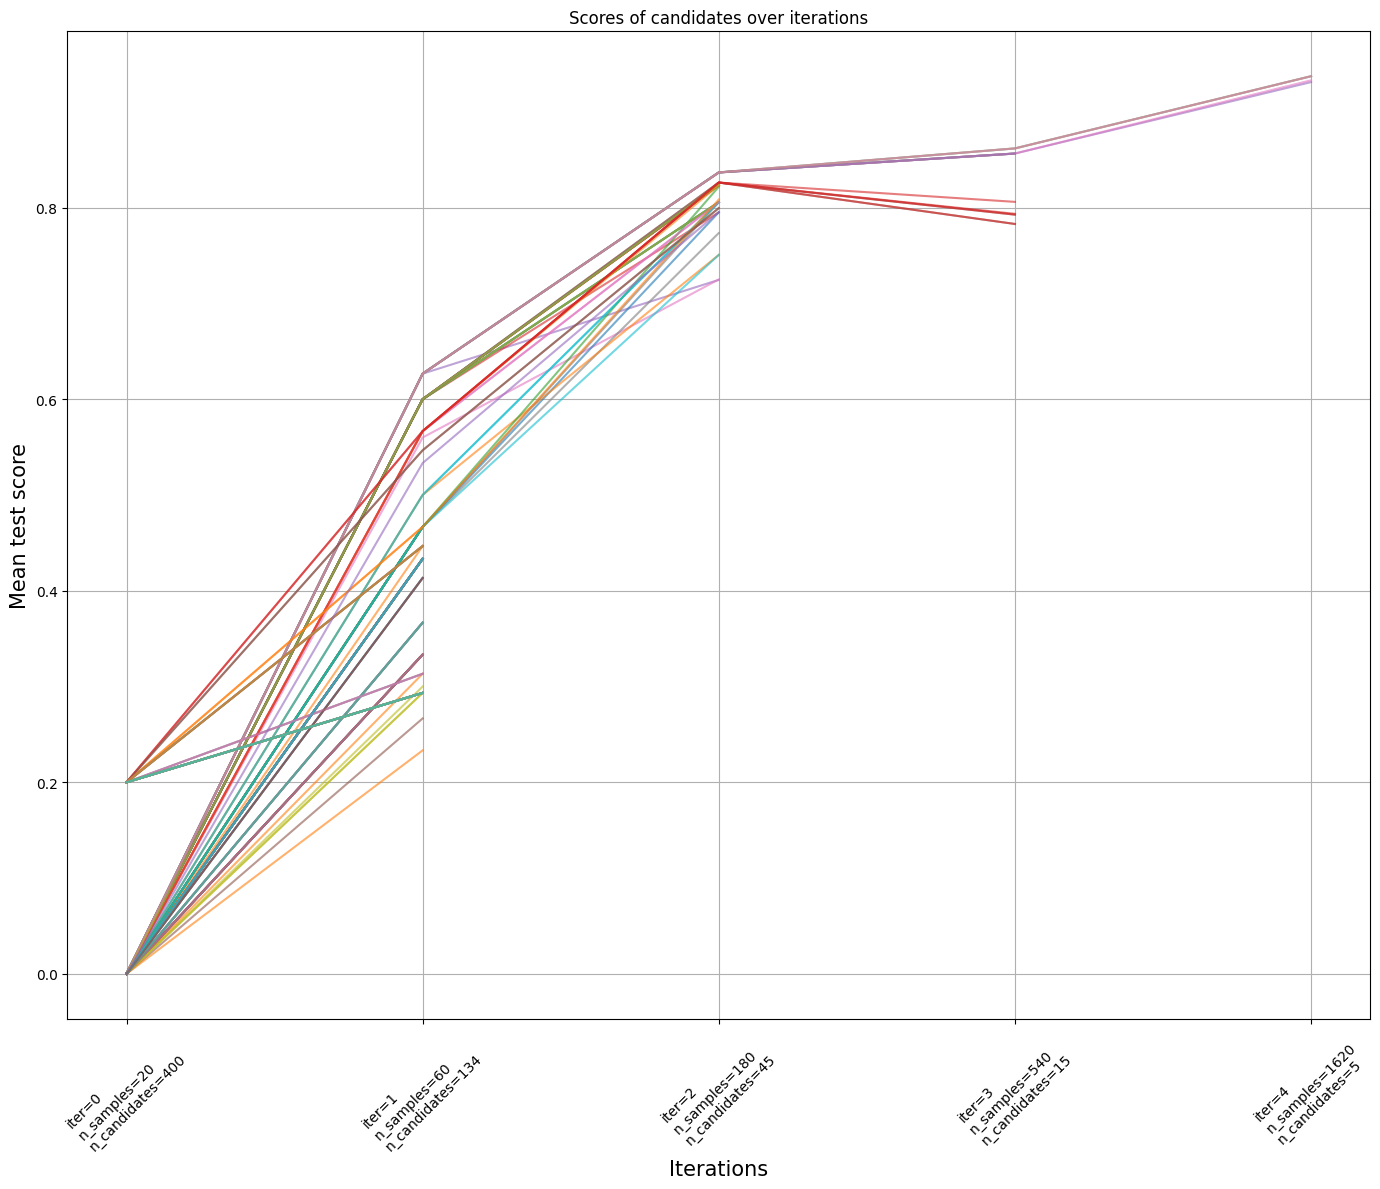

In [42]:
plot_grid(grid_search)

In [43]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))
METRICS.append(f1_score(y_test, preds))
MODELS.append("Logistic")
TUNE.append(True)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       616
           1       1.00      0.89      0.94       134

    accuracy                           0.98       750
   macro avg       0.99      0.94      0.96       750
weighted avg       0.98      0.98      0.98       750


In [ ]:
pipe = Pipeline(
    steps=[
        ("counter", CountVectorizer()),
        (
            "clf",
            DecisionTreeClassifier(
                random_state=RANDOM_STATE,
            ),
        ),
    ]
).fit(X_train, y_train)
parameter_grid = {
    "counter__max_df": np.linspace(0.5, 0.9, 5),
    "counter__min_df": [0.01, 0.05, 0.08, 0.1],
    "counter__ngram_range": ((1, 1), (1, 2)),
    "clf__min_samples_leaf": np.arange(1, 5, 1),
    "clf__max_depth": np.arange(2, 10, 2),
}

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=5,
    scoring="f1",
    random_state=RANDOM_STATE,
)
grid_search.fit(X_train, y_train)

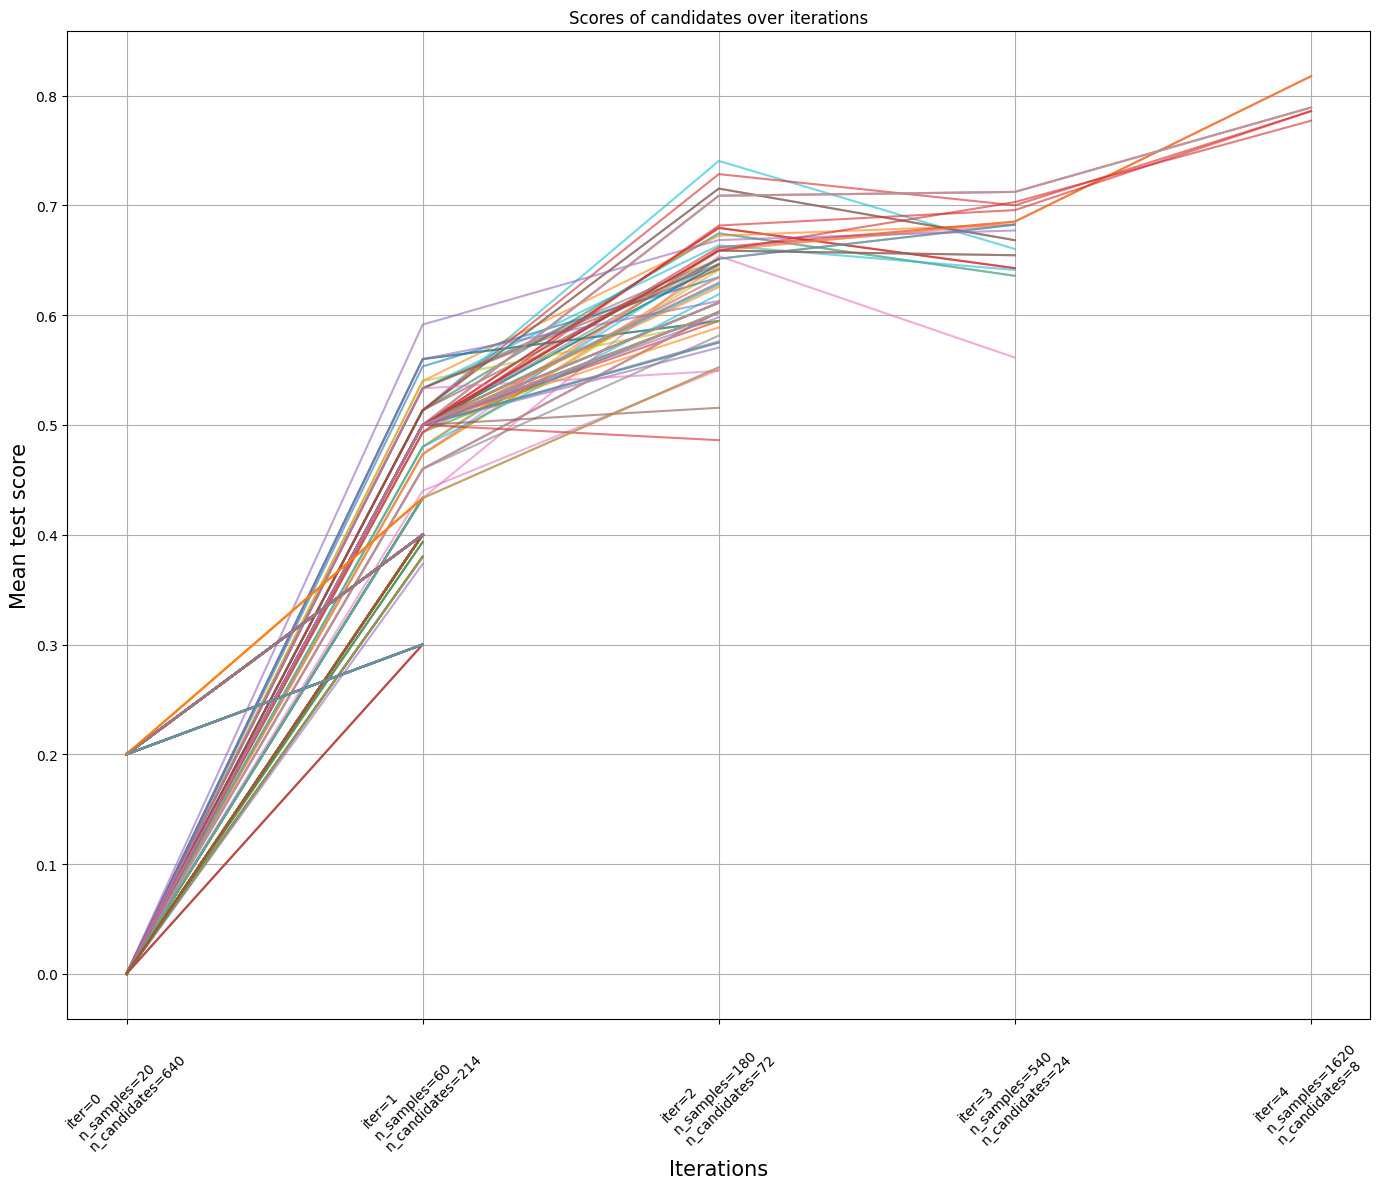

In [45]:
plot_grid(grid_search)

In [46]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))
METRICS.append(f1_score(y_test, preds))
MODELS.append("Decision Tree")
TUNE.append(True)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       616
           1       0.95      0.66      0.78       134

    accuracy                           0.93       750
   macro avg       0.94      0.83      0.87       750
weighted avg       0.93      0.93      0.93       750


In [47]:
pipe = Pipeline(steps=[("counter", CountVectorizer()), ("clf", MultinomialNB())]).fit(
    X_train, y_train
)
parameter_grid = {
    "counter__max_df": np.linspace(0.5, 0.9, 5),
    "counter__min_df": [0.01, 0.05, 0.08, 0.1],
    "counter__ngram_range": ((1, 1), (1, 2)),
    "clf__alpha": np.linspace(1, 11, 10),
}


grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=5,
    scoring="f1",
    random_state=RANDOM_STATE,
)
grid_search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 20
max_resources_: 2249
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 400
n_resources: 20
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
----------
iter: 1
n_candidates: 134
n_resources: 60
Fitting 5 folds for each of 134 candidates, totalling 670 fits
----------
iter: 2
n_candidates: 45
n_resources: 180
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 3
n_candidates: 15
n_resources: 540
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 4
n_candidates: 5
n_resources: 1620
Fitting 5 folds for each of 5 candidates, totalling 25 fits


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('clf', MultinomialNB())]),
                    n_jobs=-1,
                    param_grid={'clf__alpha': array([ 1.        ,  2.11111111,  3.22222222,  4.33333333,  5.44444444,
        6.55555556,  7.66666667,  8.77777778,  9.88888889, 11.        ]),
                                'counter__max_df': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                'counter__min_df': [0.01, 0.05, 0.08, 0.1],
                                'counter__ngram_range': ((1, 1), (1, 2))},
                    random_state=123, scoring='f1', verbose=1)

In [48]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))
METRICS.append(f1_score(y_test, preds))
MODELS.append("Naive Bayes")
TUNE.append(True)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       616
           1       0.98      0.92      0.95       134

    accuracy                           0.98       750
   macro avg       0.98      0.96      0.97       750
weighted avg       0.98      0.98      0.98       750


In [49]:
Bow_metrics = pd.DataFrame(
    {"Model": MODELS, "Metrics": METRICS, "Tune": TUNE, "Method": ["BOW"] * len(MODELS)}
).sort_values(by="Metrics", ascending=False)
Bow_metrics.sort_values(by="Metrics", ascending=False)
Bow_metrics.reset_index(drop=True, inplace=True)
Bow_metrics

,Model,Metrics,Tune,Method
0,Naive Bayes,0.949807,True,BOW
1,Logistic,0.940711,True,BOW
2,NaiveBayes,0.849206,False,BOW
3,Logistic,0.808333,False,BOW
4,DecisionTree,0.804196,False,BOW
5,Decision Tree,0.780702,True,BOW


### TfidfVectorizer

In [111]:
METRICS.clear(), TUNE.clear(), MODELS.clear();

In [51]:
pipe = Pipeline(
    steps=[
        ("counter", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", LogisticRegression()),
    ]
).fit(X_train, y_train)

# Проверка на отложенной выборке
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))
METRICS.append(f1_score(y_test, preds))
MODELS.append("Logistic")
TUNE.append(False)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       616
           1       1.00      0.75      0.86       134

    accuracy                           0.96       750
   macro avg       0.97      0.88      0.92       750
weighted avg       0.96      0.96      0.95       750


In [52]:
pipe = Pipeline(
    steps=[
        ("counter", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ]
).fit(X_train, y_train)
# Проверка на отложенной выборке
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))
METRICS.append(f1_score(y_test, preds))
MODELS.append("Decision Tree")
TUNE.append(False)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       616
           1       0.84      0.88      0.86       134

    accuracy                           0.95       750
   macro avg       0.91      0.92      0.92       750
weighted avg       0.95      0.95      0.95       750


In [53]:
pipe = Pipeline(
    steps=[
        ("counter", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
    ]
).fit(X_train, y_train)
# Проверка на отложенной выборке
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))
METRICS.append(f1_score(y_test, preds))
MODELS.append("Naive Bayes")
TUNE.append(False)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       616
           1       1.00      0.31      0.47       134

    accuracy                           0.88       750
   macro avg       0.93      0.65      0.70       750
weighted avg       0.89      0.88      0.85       750


##### Подбор гиперпараметров + кросс-валидация

In [ ]:
pipe = Pipeline(
    steps=[
        ("counter", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", LogisticRegression()),
    ]
).fit(X_train, y_train)
parameter_grid = {
    "counter__max_df": np.linspace(0.5, 0.9, 5),
    "counter__min_df": [0.01, 0.05, 0.08, 0.1],
    "counter__ngram_range": ((1, 1), (1, 2)),
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}


grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=5,
    scoring="f1",
    random_state=RANDOM_STATE,
)
grid_search.fit(X_train, y_train)

In [55]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))
METRICS.append(f1_score(y_test, preds))
MODELS.append("Logistic")
TUNE.append(True)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       616
           1       1.00      0.79      0.88       134

    accuracy                           0.96       750
   macro avg       0.98      0.90      0.93       750
weighted avg       0.96      0.96      0.96       750


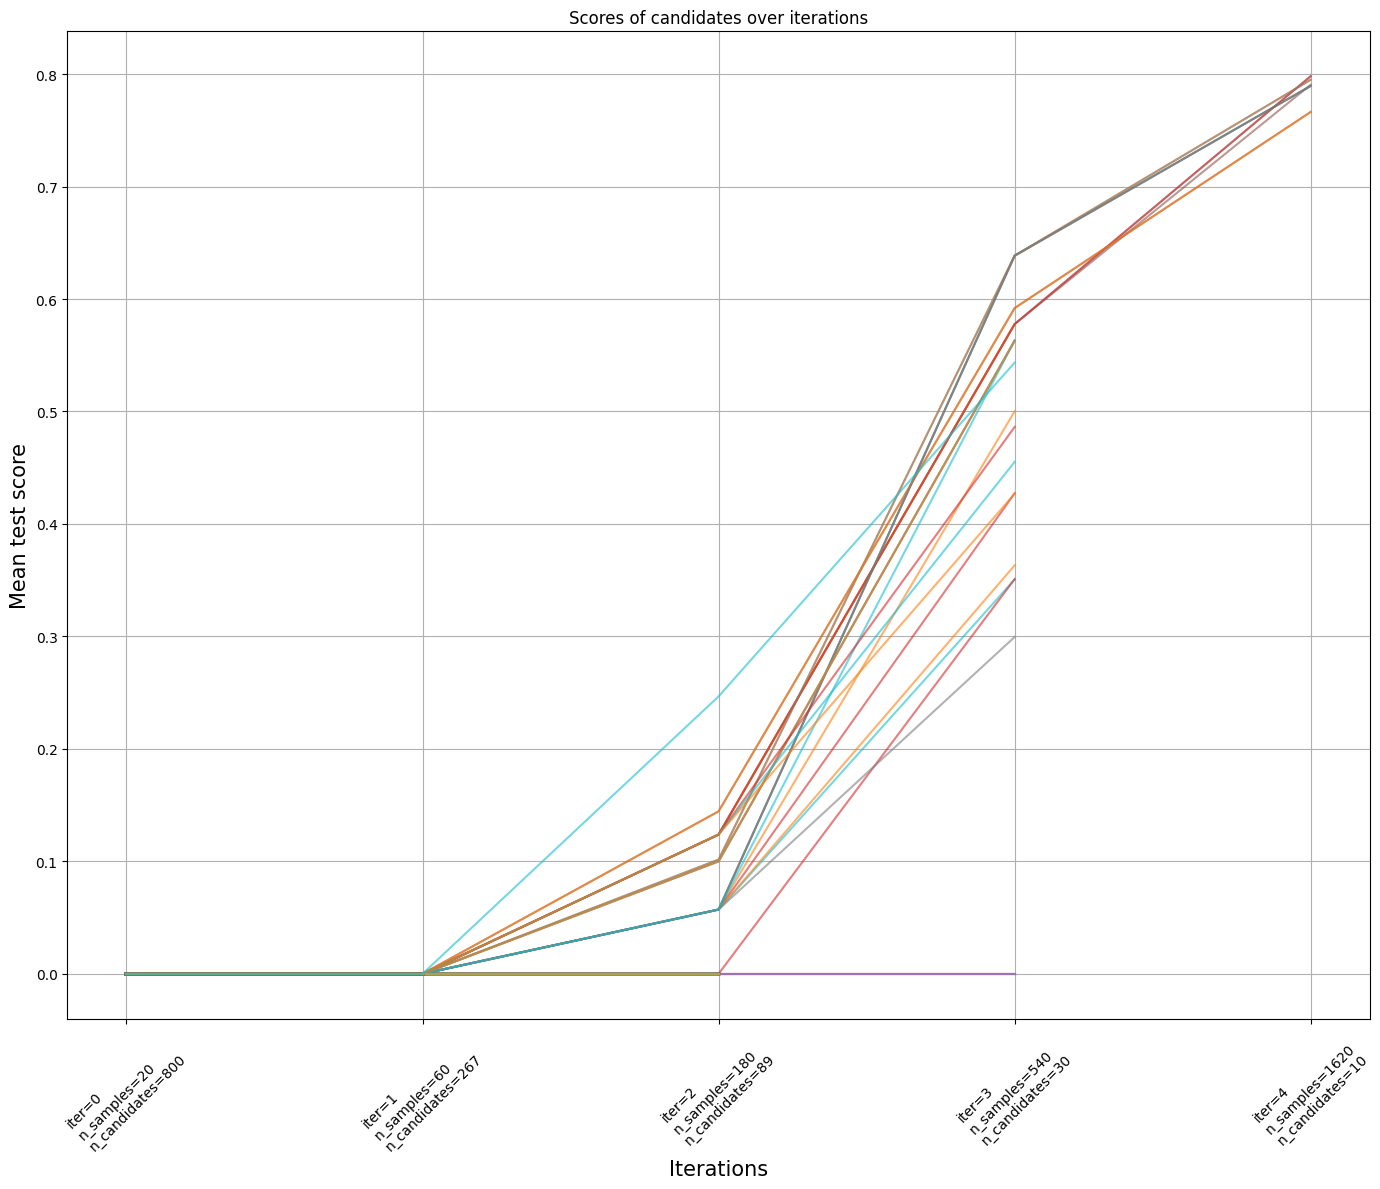

In [56]:
plot_grid(grid_search)

In [ ]:
pipe = Pipeline(
    steps=[
        ("counter", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ]
).fit(X_train, y_train)
parameter_grid = {
    "counter__max_df": np.linspace(0.5, 0.9, 5),
    "counter__min_df": [0.01, 0.05, 0.08, 0.1],
    "counter__ngram_range": ((1, 1), (1, 2)),
    "tfidf__norm": ("l1", "l2"),
    "clf__max_depth": np.arange(2, 10, 2),
    "clf__min_samples_leaf": np.arange(1, 5, 1),
}


grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=5,
    scoring="f1",
    random_state=RANDOM_STATE,
)
grid_search.fit(X_train, y_train)

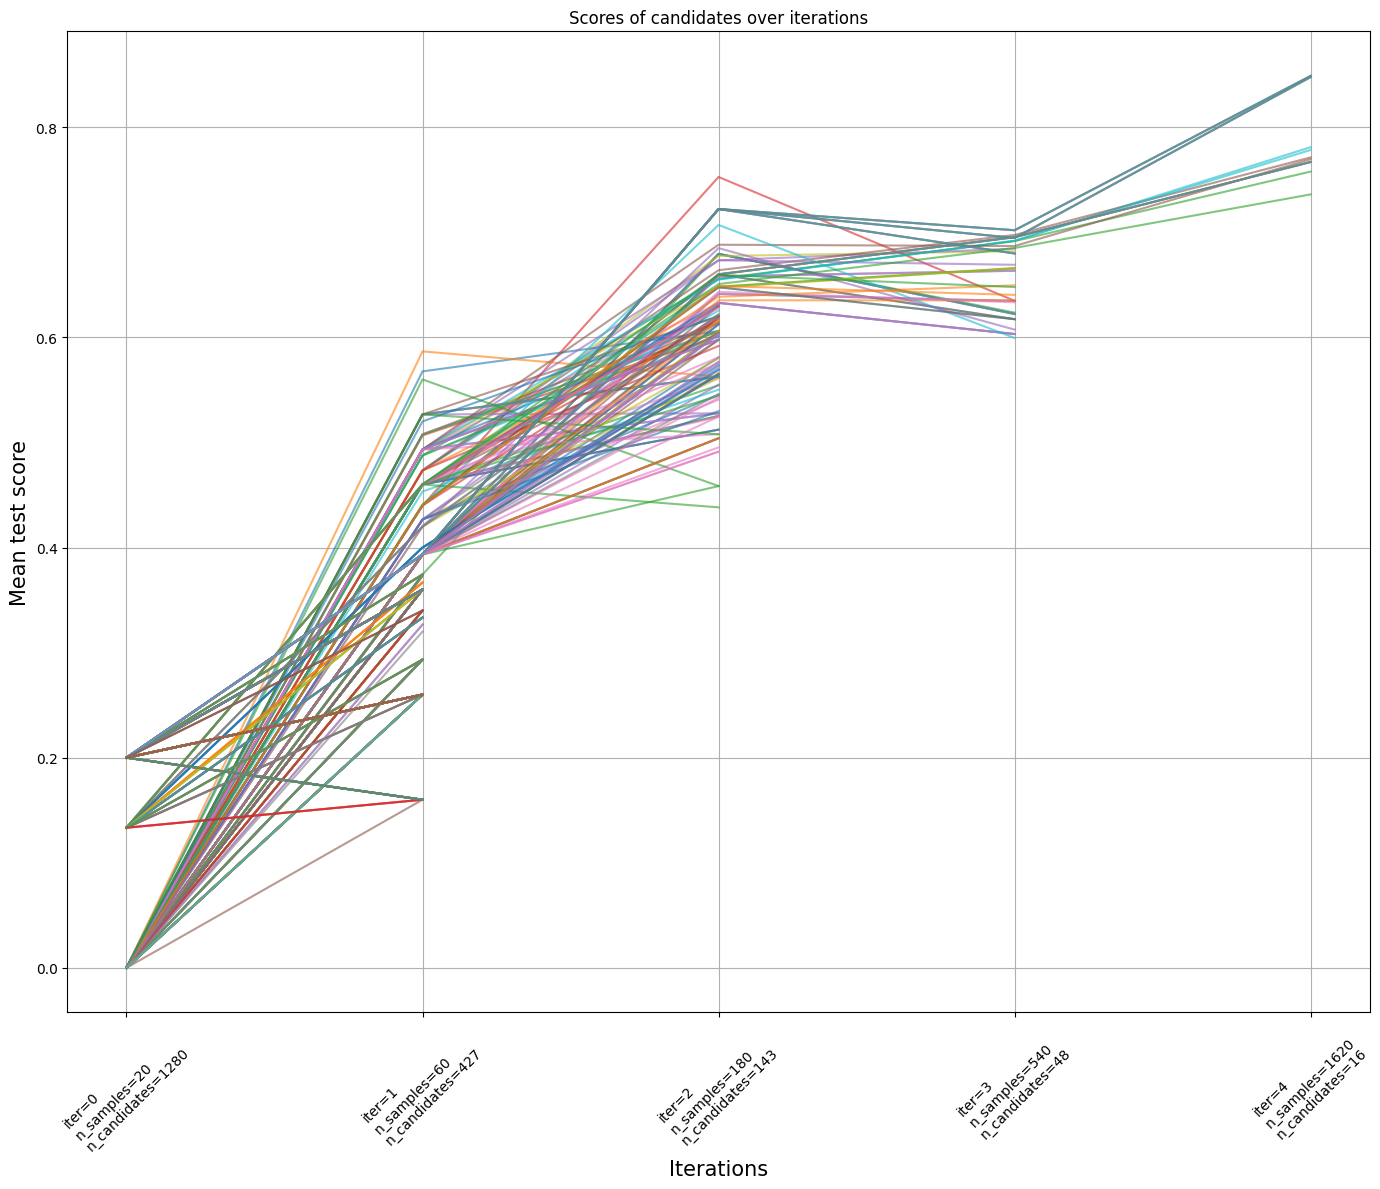

In [60]:
plot_grid(grid_search)

In [61]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))
METRICS.append(f1_score(y_test, preds))
MODELS.append("Decision Tree")
TUNE.append(True)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       616
           1       0.85      0.78      0.81       134

    accuracy                           0.94       750
   macro avg       0.90      0.87      0.89       750
weighted avg       0.93      0.94      0.93       750


In [ ]:
pipe = Pipeline(
    steps=[
        ("counter", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
    ]
).fit(X_train, y_train)
parameter_grid = {
    "counter__max_df": np.linspace(0.5, 0.9, 5),
    "counter__min_df": [0.01, 0.05, 0.08, 0.1],
    "counter__ngram_range": ((1, 1), (1, 2)),
    "tfidf__norm": ("l1", "l2"),
    "clf__alpha": np.linspace(1, 11, 10),
}


grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=5,
    scoring="f1",
    random_state=RANDOM_STATE,
)
grid_search.fit(X_train, y_train)

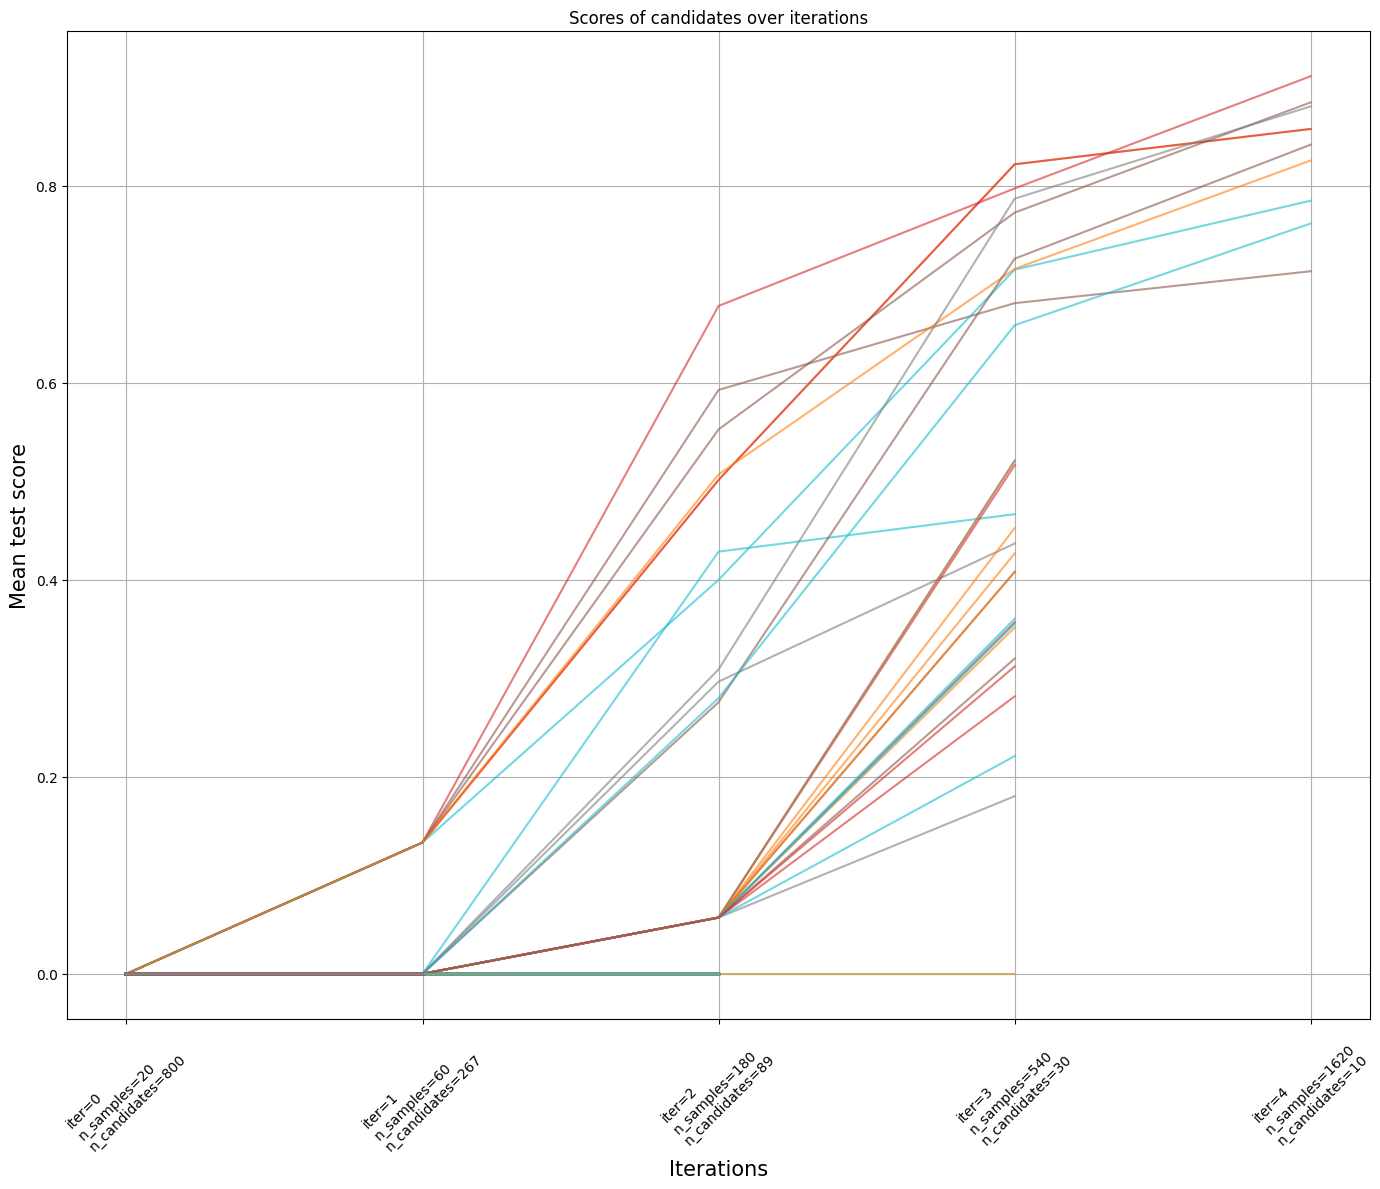

In [63]:
plot_grid(grid_search)

In [64]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))
METRICS.append(f1_score(y_test, preds))
MODELS.append("Naive Bayes")
TUNE.append(True)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       616
           1       0.98      0.84      0.91       134

    accuracy                           0.97       750
   macro avg       0.97      0.92      0.94       750
weighted avg       0.97      0.97      0.97       750


In [65]:
Tf_metrics = pd.DataFrame(
    {
        "Model": MODELS,
        "Metrics": METRICS,
        "Tune": TUNE,
        "Method": ["TF-IDF"] * len(MODELS),
    }
).sort_values(by="Metrics", ascending=False)
Tf_metrics.sort_values(by="Metrics", ascending=False)
Tf_metrics.reset_index(drop=True, inplace=True)
Tf_metrics

,Model,Metrics,Tune,Method
0,Naive Bayes,0.907631,True,TF-IDF
1,Logistic,0.883333,True,TF-IDF
2,Decision Tree,0.861314,False,TF-IDF
3,Logistic,0.859574,False,TF-IDF
4,Decision Tree,0.812500,True,TF-IDF
5,Naive Bayes,0.468571,False,TF-IDF


In [73]:
All_metrics = pd.concat([Bow_metrics, Tf_metrics], ignore_index=True)
All_metrics.sort_values(by="Metrics", ascending=False, inplace=True)
All_metrics.reset_index(drop=True, inplace=True)
All_metrics.head(5)

,Model,Metrics,Tune,Method
0,Naive Bayes,0.949807,True,BOW
1,Logistic,0.940711,True,BOW
2,Naive Bayes,0.907631,True,TF-IDF
3,Logistic,0.883333,True,TF-IDF
4,Decision Tree,0.861314,False,TF-IDF


In [106]:
print(
    f'Лучшая модель {All_metrics["Model"].iloc[0]} '
    f'с f1-score {All_metrics["Metrics"].iloc[0]}, '
    f'обучена на методе {All_metrics["Method"].iloc[0]}'
)

Лучшая модель Naive Bayes с f1-score 0.9498069498069498, обучена на методе BOW


In [110]:
Stat = All_metrics.groupby(["Method", "Tune", "Model"]).mean()
Stat

Metrics
Method Tune  Model                  
BOW    False DecisionTree   0.804196
             Logistic       0.808333
             NaiveBayes     0.849206
       True  Decision Tree  0.780702
             Logistic       0.940711
             Naive Bayes    0.949807
TF-IDF False Decision Tree  0.861314
             Logistic       0.859574
             Naive Bayes    0.468571
       True  Decision Tree  0.812500
             Logistic       0.883333
             Naive Bayes    0.907631